In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from functools import partial
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

root_path = "/data/mm/sr-press"
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
print(f"root_path: {root_path}")
sys.path.append(base_path)
sys.path.append(root_path)

base_path: /home/ubuntu/LMH/sr-press
root_path: /data/mm/sr-press


In [2]:
import express.config as config
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.simulates import expressXGBoostComponent, exPressPytorchComponent
from express.utils import add_names
from express.visualization import plot_action

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Component Prediction

In [3]:
# Configuration
# model = "soccermap" #"soccermap"
# trial = 15 # 15
model = "xgboost" #"soccermap"
trial = 503 # 15


path = Path(base_path) / "stores" / "model" / model / f"{trial:03d}" / "component.pkl"
with path.open(mode="rb") as file:
    component = pickle.load(file)
component

In [4]:
# TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
TEST_DB_PATH = os.path.join(root_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
# dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))
dataset_test = partial(PressingDataset, path=os.path.join(root_path, "stores", "datasets", "test"))

component.test(dataset_test)

{'precision': 0.7124582869855395,
 'recall': 0.5224306688417618,
 'f1': 0.6028235294117648,
 'log_loss': 0.31629473141861647,
 'brier': 0.09718685378148281,
 'roc_auc': 0.8902740534681394}

In [5]:
preds = component.predict(dataset_test)
preds

game_id  action_id
3857255  6            0.017046
         17           0.002023
         22           0.004703
         25           0.034165
         40           0.008471
                        ...   
3895348  2818         0.021307
         2834         0.092303
         2847         0.007941
         2848         0.004963
         2853         0.095115
Length: 12406, dtype: float32

In [6]:
test_games = test_db.games()
test_games.head()

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3857255,106,43,3,2022-12-01 21:00:00,778,772,Group Stage,2,1,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes
3857256,106,43,3,2022-12-02 21:00:00,786,773,Group Stage,2,3,Stadium 974,Fernando Andrés Rapallini
3857257,106,43,3,2022-11-30 17:00:00,792,776,Group Stage,1,0,Al Janoub Stadium,Mustapha Ghorbal
3857260,106,43,3,2022-11-30 21:00:00,799,794,Group Stage,1,2,Lusail Stadium,Michael Oliver
3857261,106,43,3,2022-11-29 21:00:00,907,768,Group Stage,0,3,Ahmad bin Ali Stadium,Slavko Vinčić


In [14]:
from socceraction.data.statsbomb import StatsBombLoader
SBL = StatsBombLoader(getter="remote")
competitions = SBL.competitions()

<Axes: title={'center': 'pressing & success: 0.59732 | 12 : 14.38'}>

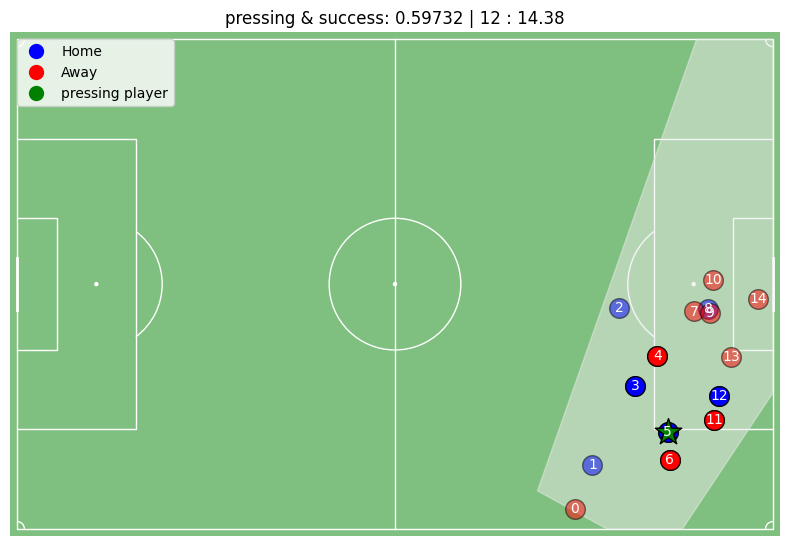

In [8]:
# game_id = 3895202
# action_id = 555
game_id = 3857255
action_id = 428

idx = (game_id, action_id)
print()
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)
actions = add_names(test_db.actions(game_id))


# plot_action(actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[idx].iloc[0])
plot_action(actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[idx])

In [9]:
game_row = test_games.loc[game_id]
competition_name = competitions[(competitions['season_id']==game_row['season_id']) & (competitions['competition_id']==game_row['competition_id'])]

print(f"{competition_name['season_name'].iloc[0]} | {competition_name['competition_name'].iloc[0]}")

teams = SBL.teams(game_id)
home_team_name = teams[teams['team_id']==home_team_id]['team_name'].iloc[0]
away_team_name = teams[teams['team_id']==away_team_id]['team_name'].iloc[0]
print(f"{home_team_name} vs {away_team_name}")

2022 | FIFA World Cup


Japan vs Spain


## Optimal Pressing Simulation

In [10]:
# TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
TEST_DB_PATH = os.path.join(root_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
# dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))
dataset_test = partial(PressingDataset, path=os.path.join(root_path, "stores", "datasets", "test"))

if model == "xgboost":
    test_dataset = PressingDataset(
        # path= os.path.join(base_path, "stores", "datasets", "test"),
        path= os.path.join(root_path, "stores", "datasets", "test"),
        xfns=["startlocation", "closest_11_players"],
        yfns=["counterpress"],
        load_cached=True,
        nb_prev_actions=3
    )
    simulater = expressXGBoostComponent(test_db, component, 
                                        xfns= test_dataset.xfns.keys(), nb_prev_actions=3)
elif model == "soccermap":
    test_dataset = PressingDataset(
        path= os.path.join(base_path, "stores", "datasets", "test"),
        xfns=["startlocation", "freeze_frame_360"],
        yfns=["counterpress"],
        load_cached=True,
        nb_prev_actions=1
    )
    simulater = exPressPytorchComponent(test_db, component, 
                                        xfns= test_dataset.xfns.keys(), labels=test_dataset.labels, nb_prev_actions=1)

simulater

In [11]:
temp_row = test_dataset.labels[test_dataset.labels['counterpress']==True].reset_index().iloc[1]
game_id = temp_row['game_id']
action_id = temp_row['action_id']
# game_id = 3857264
# action_id = 2387

game_row = test_games.loc[game_id]
competition_name = competitions[(competitions['season_id']==game_row['season_id']) & (competitions['competition_id']==game_row['competition_id'])]

print(f"{competition_name['season_name'].iloc[0]} | {competition_name['competition_name'].iloc[0]}")
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)
teams = SBL.teams(game_id)
home_team_name = teams[teams['team_id']==home_team_id]['team_name'].iloc[0]
away_team_name = teams[teams['team_id']==away_team_id]['team_name'].iloc[0]
print(f"{home_team_name} vs {away_team_name}")

2022 | FIFA World Cup
Japan vs Spain


In [125]:
game_id, action_id

(3857255, 163)

<Axes: title={'center': 'pressing & success: 0.23280 | 4 : 9.99'}>

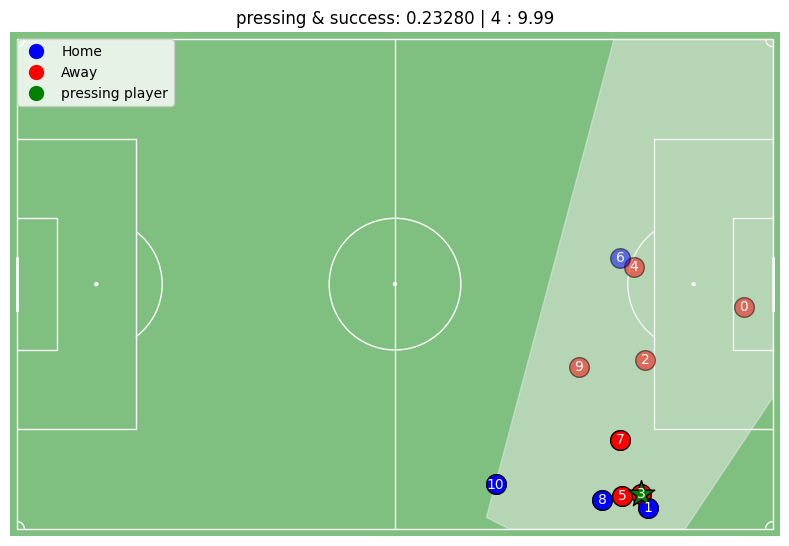

In [12]:
actions = add_names(test_db.actions(game_id))
idx = (game_id, action_id)
plot_action(actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[idx])

In [ ]:
actions = add_names(test_db.actions(game_id))
idx = (game_id, action_id)
actions.loc[idx]

original_event_id                   97b73204-2a88-4467-801e-265232f3af9d
period_id                                                              1
time_seconds                                                     249.989
team_id                                                              772
player_id                                                           6892
start_x                                                            87.15
start_y                                                             4.42
end_x                                                              87.15
end_y                                                               4.42
bodypart_id                                                            0
type_id                                                               23
result_id                                                              1
possession_team_id                                                 772.0
play_pattern_name                                  

In [123]:
game_id, action_id

(3857257, 1267)

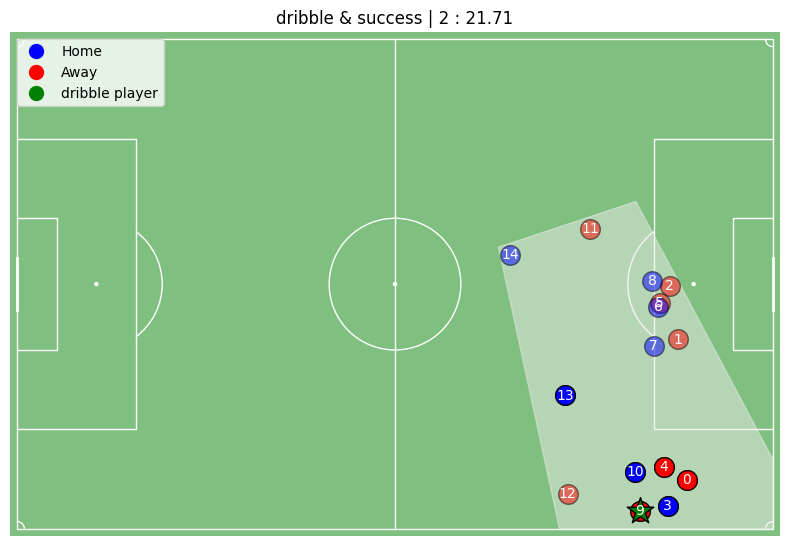

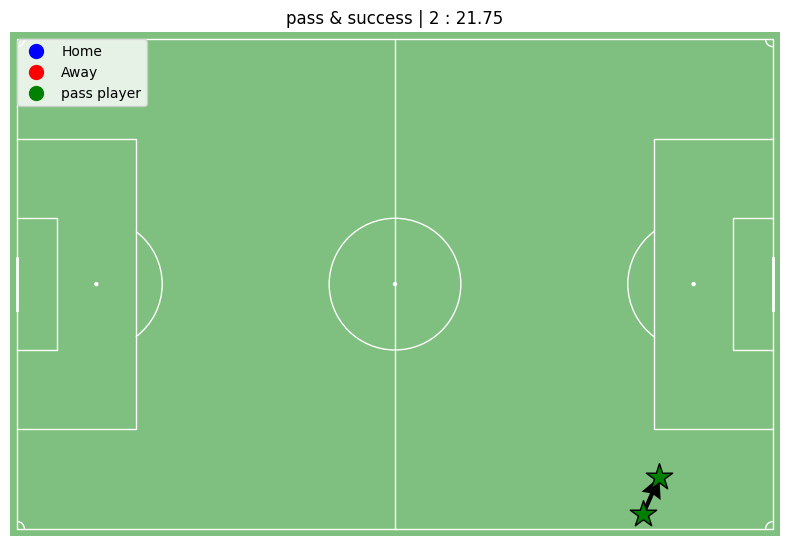

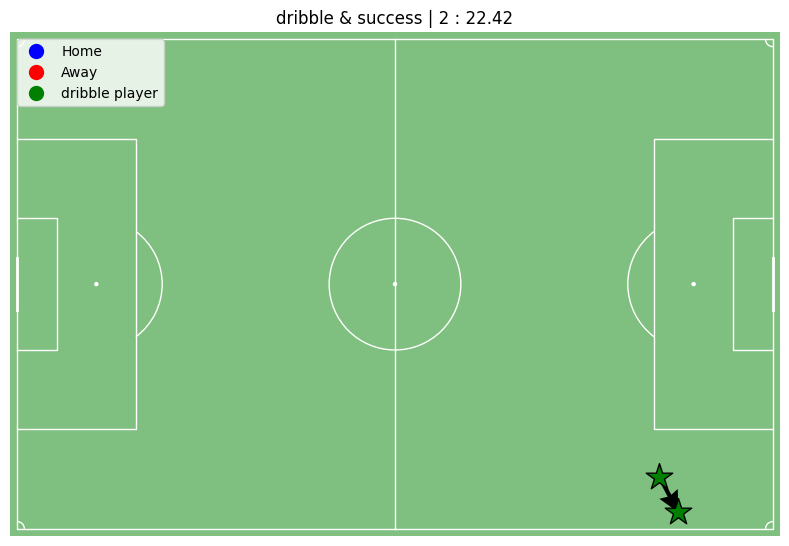

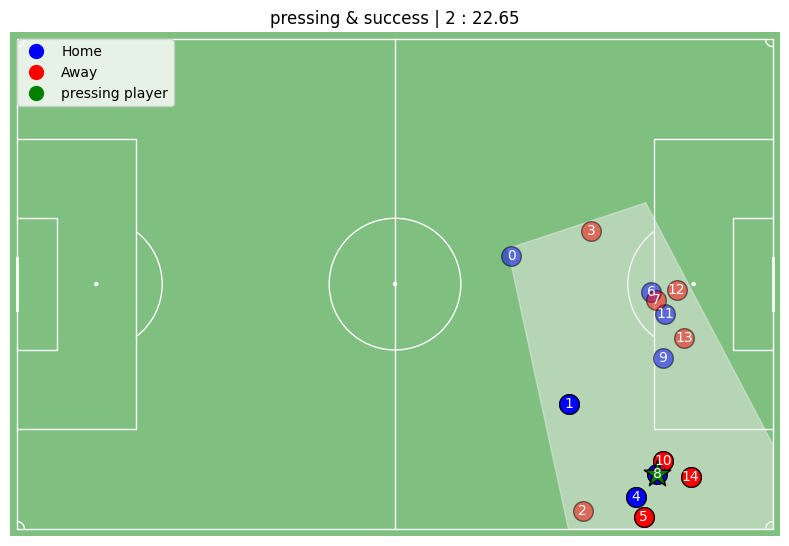

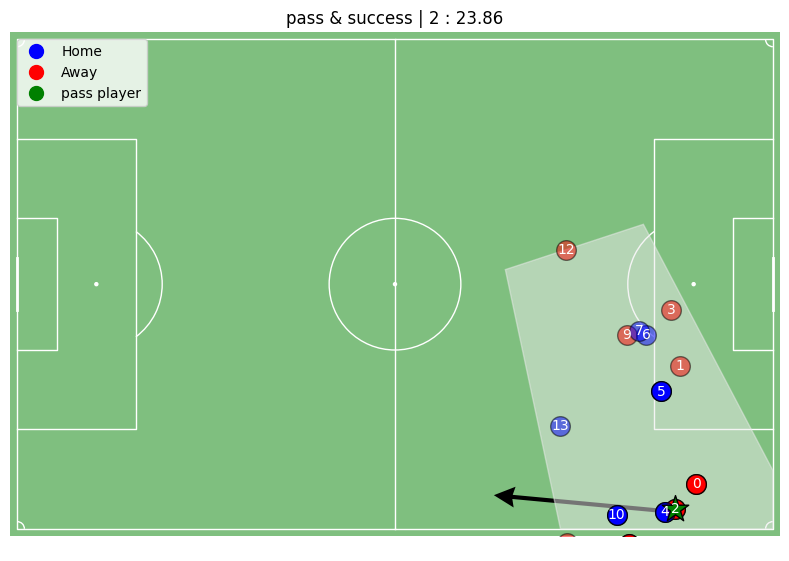

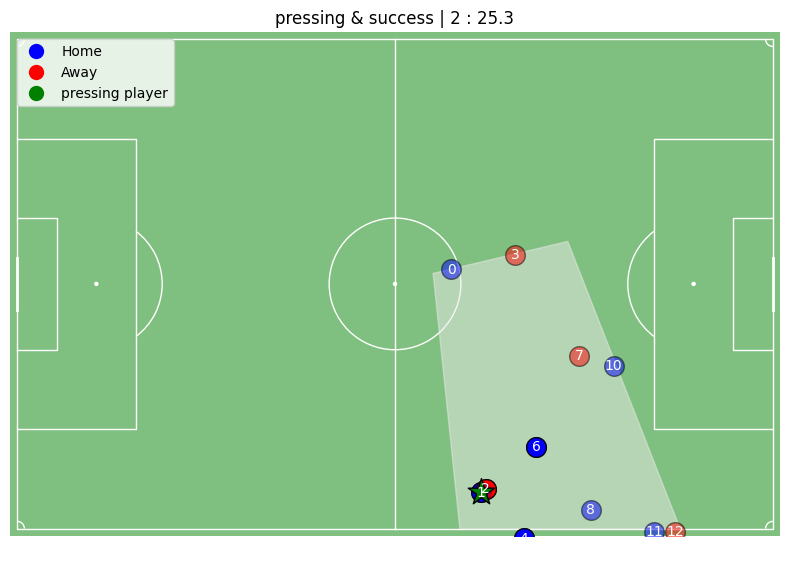

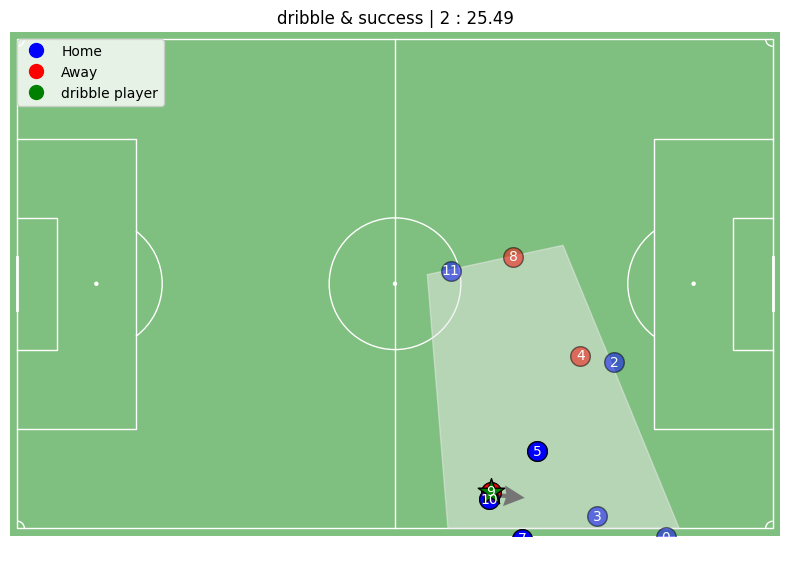

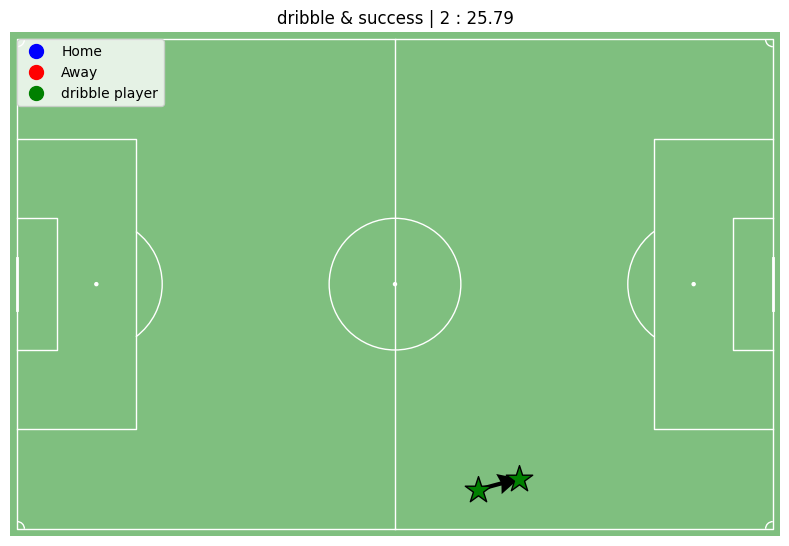

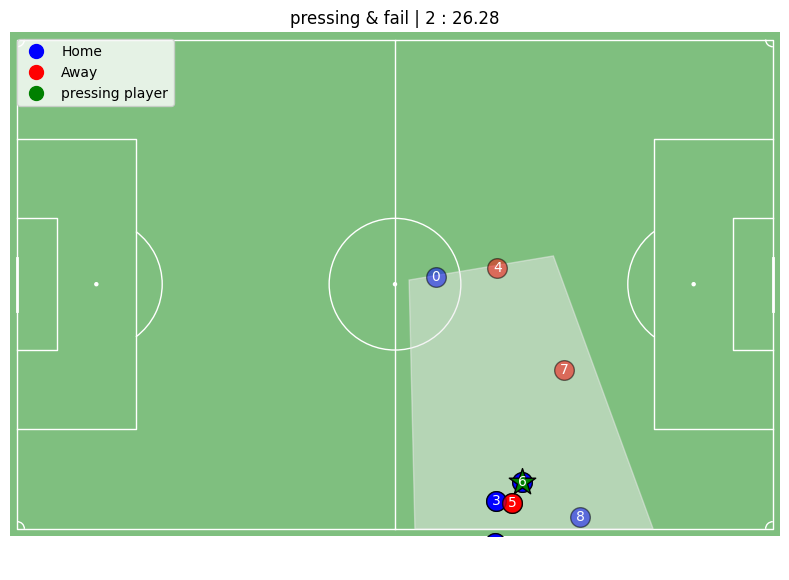

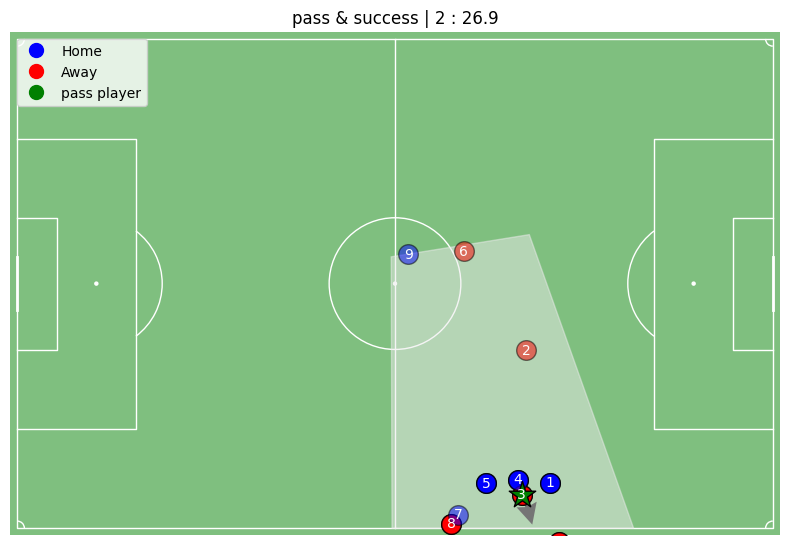

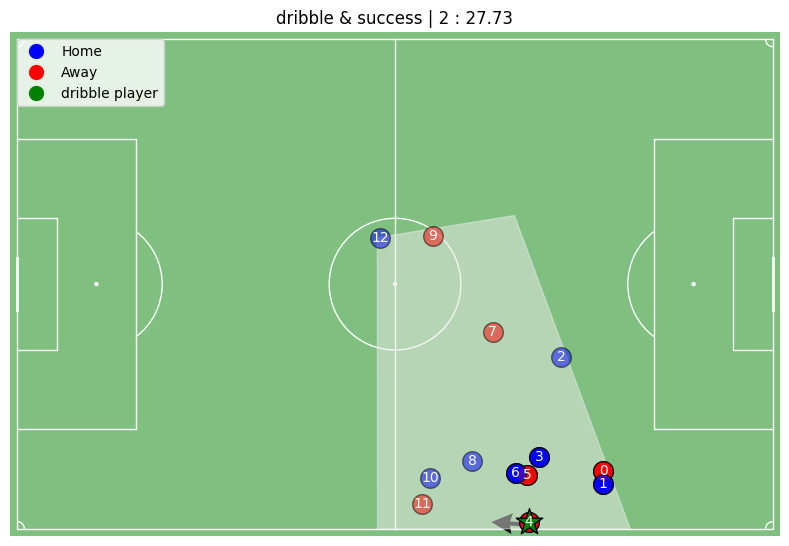

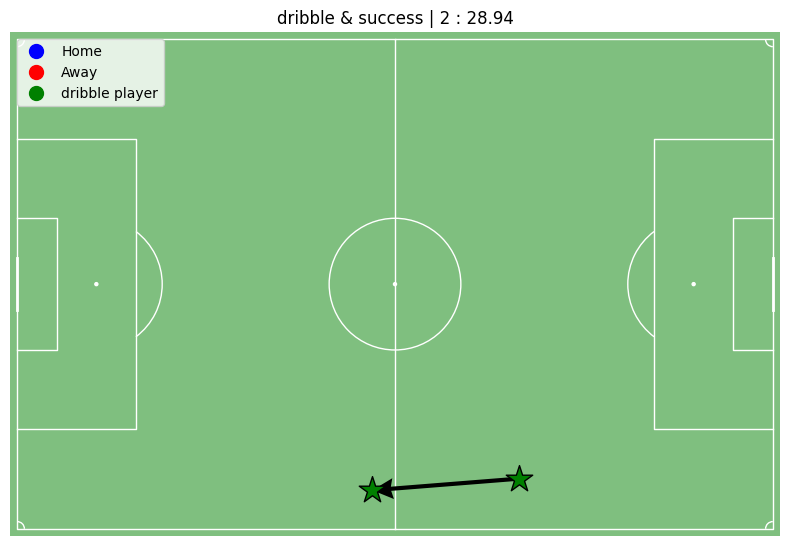

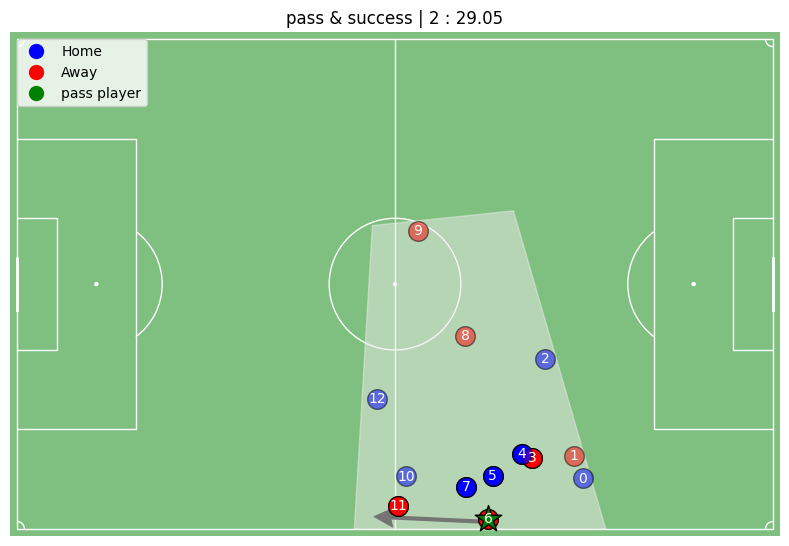

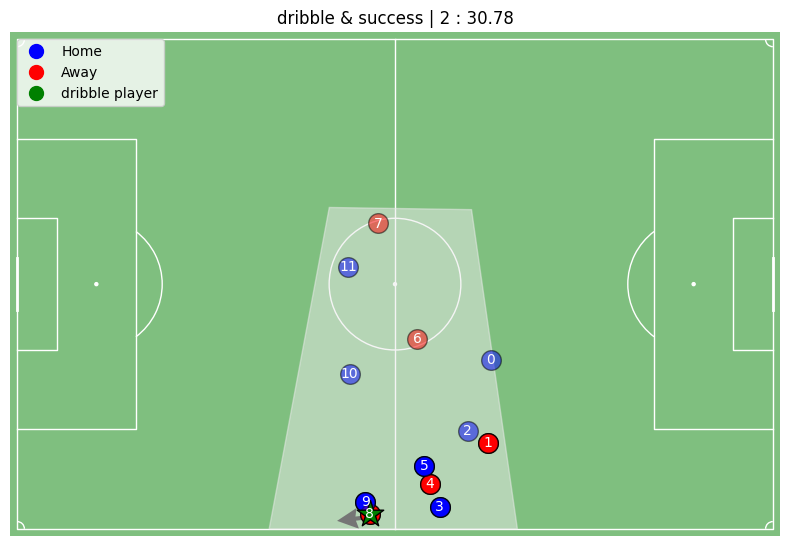

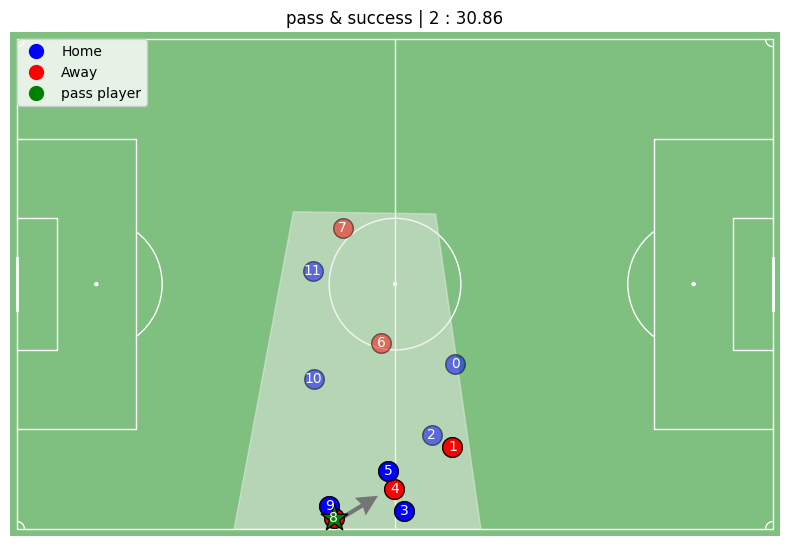

In [120]:
for i in range(-5, 10):
    idx = (game_id, action_id + i)
    # plot_action(actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[idx])
    plot_action(actions.loc[idx], home_team_id=home_team_id, prob=None)

In [15]:
df_events = SBL.events(game_id=game_id)

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterpress"] = eventsdf["counterpress"].fillna(False).astype(bool)


In [19]:
df_events[df_events['type_name']=="Pass"]

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,second,possession,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
4,3857255,8b26aef6-09bc-4cc7-87a8-2b547c0b44f7,1,772,133353.0,30,Pass,5,0 days 00:00:00.540000,0,0,2,772,Spain,9,From Kick Off,Spain,1.793392,"{'pass': {'recipient': {'id': 6892, 'name': 'P...",[8a5e501f-a22e-4371-83c0-c62fb33fd3f2],Pablo Martín Páez Gavira,13.0,Right Center Midfield,"[61.0, 40.1]",False,False
7,3857255,57365d40-4701-486a-8c96-ed35af64f4eb,1,772,6892.0,30,Pass,8,0 days 00:00:03.723000,0,3,2,772,Spain,9,From Kick Off,Spain,2.655969,"{'pass': {'recipient': {'id': 68574, 'name': '...","[368d9a8b-7c8e-4dc2-9363-8aac056dae54, fdd4071...",Pau Francisco Torres,5.0,Left Center Back,"[33.5, 32.7]",False,False
10,3857255,5aff0d66-50f1-4b05-893d-266b0964519a,1,772,3957.0,30,Pass,11,0 days 00:00:12.931000,0,12,3,772,Spain,4,From Throw In,Spain,1.003935,"{'pass': {'recipient': {'id': 6765, 'name': 'R...",[717a7a54-e7bb-4d87-bc41-200bdf7d62df],César Azpilicueta Tanco,2.0,Right Back,"[49.6, 80.0]",False,False
13,3857255,56daf5d9-7863-47a1-a0fd-f77efa541e0b,1,772,6765.0,30,Pass,14,0 days 00:00:16.360000,0,16,3,772,Spain,4,From Throw In,Spain,2.558932,"{'pass': {'recipient': {'id': 6892, 'name': 'P...","[a36683f8-3c11-4640-bb81-2db5473856df, e8c07b4...",Rodrigo Hernández Cascante,3.0,Right Center Back,"[15.5, 62.8]",True,False
16,3857255,01fc93fa-5331-45a8-8aad-1e8dc8747d3e,1,772,6892.0,30,Pass,17,0 days 00:00:22.838000,0,22,3,772,Spain,4,From Throw In,Spain,1.510414,"{'pass': {'recipient': {'id': 6765, 'name': 'R...",[d006f044-08fa-4274-9d97-2754433cdc89],Pau Francisco Torres,5.0,Left Center Back,"[31.2, 28.7]",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436,3857255,33b22dfa-880b-40e4-978e-05eba83f46aa,2,772,11748.0,30,Pass,4437,0 days 00:51:46.826000,96,46,136,772,Spain,4,From Throw In,Spain,1.931185,"{'pass': {'recipient': {'id': 6765, 'name': 'R...",[419c2c84-9f63-41bf-bf2e-033ecfbaa4f9],Unai Simón Mendibil,1.0,Goalkeeper,"[18.5, 39.9]",False,False
4439,3857255,d0d61e24-8eb5-4622-82ee-dabaf0536be5,2,772,6765.0,30,Pass,4440,0 days 00:51:50.124000,96,50,136,772,Spain,4,From Throw In,Spain,1.762443,"{'pass': {'recipient': {'id': 30486, 'name': '...",[86da4a6e-2115-441a-b6d4-0b1806b77004],Rodrigo Hernández Cascante,3.0,Right Center Back,"[48.2, 51.7]",False,False
4442,3857255,588ac8a5-36f9-47c6-855f-2862d93bcff0,2,772,30486.0,30,Pass,4443,0 days 00:51:53,96,53,136,772,Spain,4,From Throw In,Spain,1.683015,"{'pass': {'recipient': {'id': 5211, 'name': 'J...",[89312224-9933-4325-a7b4-c99dfa7e522b],Pedro González López,15.0,Left Center Midfield,"[62.8, 25.5]",False,False
4445,3857255,41ac49d4-3ec4-4abe-b663-6fe5de899d20,2,772,5211.0,30,Pass,4446,0 days 00:51:55.918000,96,55,136,772,Spain,4,From Throw In,Spain,0.504766,"{'pass': {'length': 15.700318, 'angle': 1.0872...",[0536f33e-3445-492d-9cc1-dc1a1507dd16],Jordi Alba Ramos,6.0,Left Back,"[92.5, 3.6]",False,False


In [16]:
import pandas as pd

# 컬럼 개수 제한 해제
pd.set_option('display.max_columns', None)

df_events[df_events['type_name']=="Pressure"]

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,second,possession,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
12,3857255,a36683f8-3c11-4640-bb81-2db5473856df,1,778,30628.0,17,Pressure,13,0 days 00:00:15.985000,0,15,3,772,Spain,4,From Throw In,Japan,0.601877,{},[56daf5d9-7863-47a1-a0fd-f77efa541e0b],Daizen Maeda,23.0,Center Forward,"[98.4, 14.9]",False,False
28,3857255,f1c8d51a-b3b0-41f1-96a8-aeead3466355,1,778,9411.0,17,Pressure,29,0 days 00:00:40.472000,0,40,3,772,Spain,4,From Throw In,Japan,0.710283,{},"[47753a80-d704-473e-9c36-20d2292d5170, 583689f...",Daichi Kamada,21.0,Left Wing,"[58.7, 13.0]",False,False
35,3857255,2d76029c-d45c-4608-880d-9bee542ba88c,1,778,31090.0,17,Pressure,36,0 days 00:00:45.512000,0,45,3,772,Spain,4,From Throw In,Japan,0.969101,{},"[1e99a12c-fbcc-44bc-98ce-ddc4fe8d57d9, 8e5ac67...",Takefusa Kubo,17.0,Right Wing,"[65.0, 67.7]",False,False
37,3857255,2fa0477e-7533-403a-87fb-23ee349a4692,1,778,9411.0,17,Pressure,38,0 days 00:00:47.942000,0,47,3,772,Spain,4,From Throw In,Japan,0.555879,{},"[583d4f7f-9567-4cbe-8119-497d76ab49e7, 7c437a7...",Daichi Kamada,21.0,Left Wing,"[74.8, 29.9]",False,False
49,3857255,b85f4f8b-d87f-481d-ac17-4d934de2ffb3,1,778,30628.0,17,Pressure,50,0 days 00:00:56.441000,0,56,3,772,Spain,4,From Throw In,Japan,0.575441,{},"[52d3e5c2-0dbf-4286-9309-91aed3ef14ae, c8cf001...",Daizen Maeda,23.0,Center Forward,"[75.0, 26.3]",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,3857255,b250e609-c9d3-40d1-9fcb-1ae973bde5d2,2,778,37211.0,17,Pressure,4308,0 days 00:48:36.163000,93,36,133,772,Spain,4,From Throw In,Japan,0.450291,{},"[8f0148d6-f25e-4524-99e3-06ad7c8f64ef, cfed749...",Kaoru Mitoma,8.0,Left Wing Back,"[32.1, 14.1]",False,False
4312,3857255,163b1cbc-6b83-487f-9e85-79e020034baf,2,778,8949.0,17,Pressure,4313,0 days 00:48:41.297000,93,41,133,772,Spain,4,From Throw In,Japan,0.574871,{},"[0748f1cc-766e-47f1-b392-0c1dfffe6b5c, c155c11...",Takuma Asano,23.0,Center Forward,"[76.1, 22.3]",False,False
4335,3857255,5b2bf9cb-0b1c-49e3-9382-394a3758bc12,2,778,37211.0,17,Pressure,4336,0 days 00:49:03.222000,94,3,133,772,Spain,4,From Throw In,Japan,0.450167,{},[],Kaoru Mitoma,8.0,Left Wing Back,"[17.1, 24.0]",False,False
4360,3857255,75c02079-85f6-4667-903f-b2a258d0a6b1,2,778,37211.0,17,Pressure,4361,0 days 00:49:43.853000,94,43,134,772,Spain,4,From Throw In,Japan,0.679183,{},[055a0bb9-4c0f-4a78-9d4a-37134e4f1b3b],Kaoru Mitoma,8.0,Left Wing Back,"[33.1, 9.2]",False,False


In [80]:
df_events = SBL.events(game_id=game_id)
idx = (game_id, action_id -4)
df_events[df_events['event_id']==actions.loc[idx]['original_event_id']]

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterpress"] = eventsdf["counterpress"].fillna(False).astype(bool)


,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
228,3857255,5a4ef0cf-daf6-47f2-b7aa-7c9d02264d20,1,778,30628.0,17,Pressure,229,0 days 00:04:04.800000,4,...,Japan,0.6826,{},"[33ea8cd5-5a9b-465e-bcf6-c9059145805a, 5bae2e8...",Daizen Maeda,23.0,Center Forward,"[74.6, 55.2]",False,False


In [66]:
df_events = SBL.events(game_id=game_id)
idx = (game_id, action_id + 1)
df_events[df_events['event_id']==actions.loc[idx]['original_event_id']]

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterpress"] = eventsdf["counterpress"].fillna(False).astype(bool)


,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
3547,3857264,7c3b7523-c356-4dbd-977a-d3ebc7248e04,2,789,44166.0,30,Pass,3548,0 days 00:39:59.352000,84,...,Poland,1.449394,"{'pass': {'length': 25.428528, 'angle': 2.2977...",[51524a1c-b4ae-4b42-9afe-2a0503e1681b],Jakub Piotr Kiwior,5.0,Left Center Back,"[42.2, 8.5]",False,False


In [40]:
player_ids = [6, 9]
freeze_frame_360 = pd.DataFrame(actions.loc[idx]["freeze_frame_360"])

# range: -5m ~ 5m
dx_range = range(-5, 6) 
dy_range = range(-5, 6)
pos_by_players = {}
for player_id in player_ids:
    x, y = freeze_frame_360.loc[player_id, ["x", "y"]]
    pos = [(x + dx, y + dy) for dx in dx_range for dy in dy_range]
    pos_by_players[player_id] = pos

simulated_instances = simulater.simulate(game_id= game_id, action_id=action_id, pos_by_players=pos_by_players)
simulated_instances

Simulating with xgboost model: 100%|██████████| 14642/14642 [08:16<00:00, 29.47it/s]


 ...]

In [31]:
raw_instance = next((instance for instance in simulated_instances if instance.is_raw), None)
if not raw_instance:
    raise ValueError("raw가 True인 인스턴스가 없습니다.")

k = 8
sorted_instances = sorted(
    [instance for instance in simulated_instances if not instance.is_raw],
    key=lambda x: x.prob,
    reverse=True
)

instances = [raw_instance] + sorted_instances[:k]
for instance in instances:
    print(f"{instance}: {instance.prob : .3f}")

<express.simulates.SimulatedInstance object at 0x7fc07eb1a8b0>:  0.200
<express.simulates.SimulatedInstance object at 0x7fc012123bb0>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc010d22e50>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc0120d50d0>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc010cd2dc0>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc012166910>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc010d7de50>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc012084340>:  0.234
<express.simulates.SimulatedInstance object at 0x7fc010cf7df0>:  0.234


In [32]:
def _fix_direction_of_play(actions: pd.DataFrame, home_team_id: int) -> pd.DataFrame:
    away_idx = (actions.team_id != home_team_id).values
    for col in ["start_x", "end_x"]:
        actions.loc[away_idx, col] = config.field_length - actions[away_idx][col].values
    for col in ["start_y", "end_y"]:
        actions.loc[away_idx, col] = config.field_width - actions[away_idx][col].values

    return actions

def _sb_freeze_frame_to_spadl(freeze_frame,invert: bool = False):
    if not isinstance(freeze_frame, list):
        return None
    freezedf = pd.DataFrame(
        {
            "teammate": e["teammate"],
            "actor": e["actor"],
            "keeper": e["keeper"],
            "x": e["x"],
            "y": e["y"],
        }
        for e in freeze_frame
    )

    if invert:
        freezedf["x"] = config.field_length - freezedf["x"].values
        freezedf["y"] = config.field_width - freezedf["y"].values
    return list(freezedf.to_dict("records"))

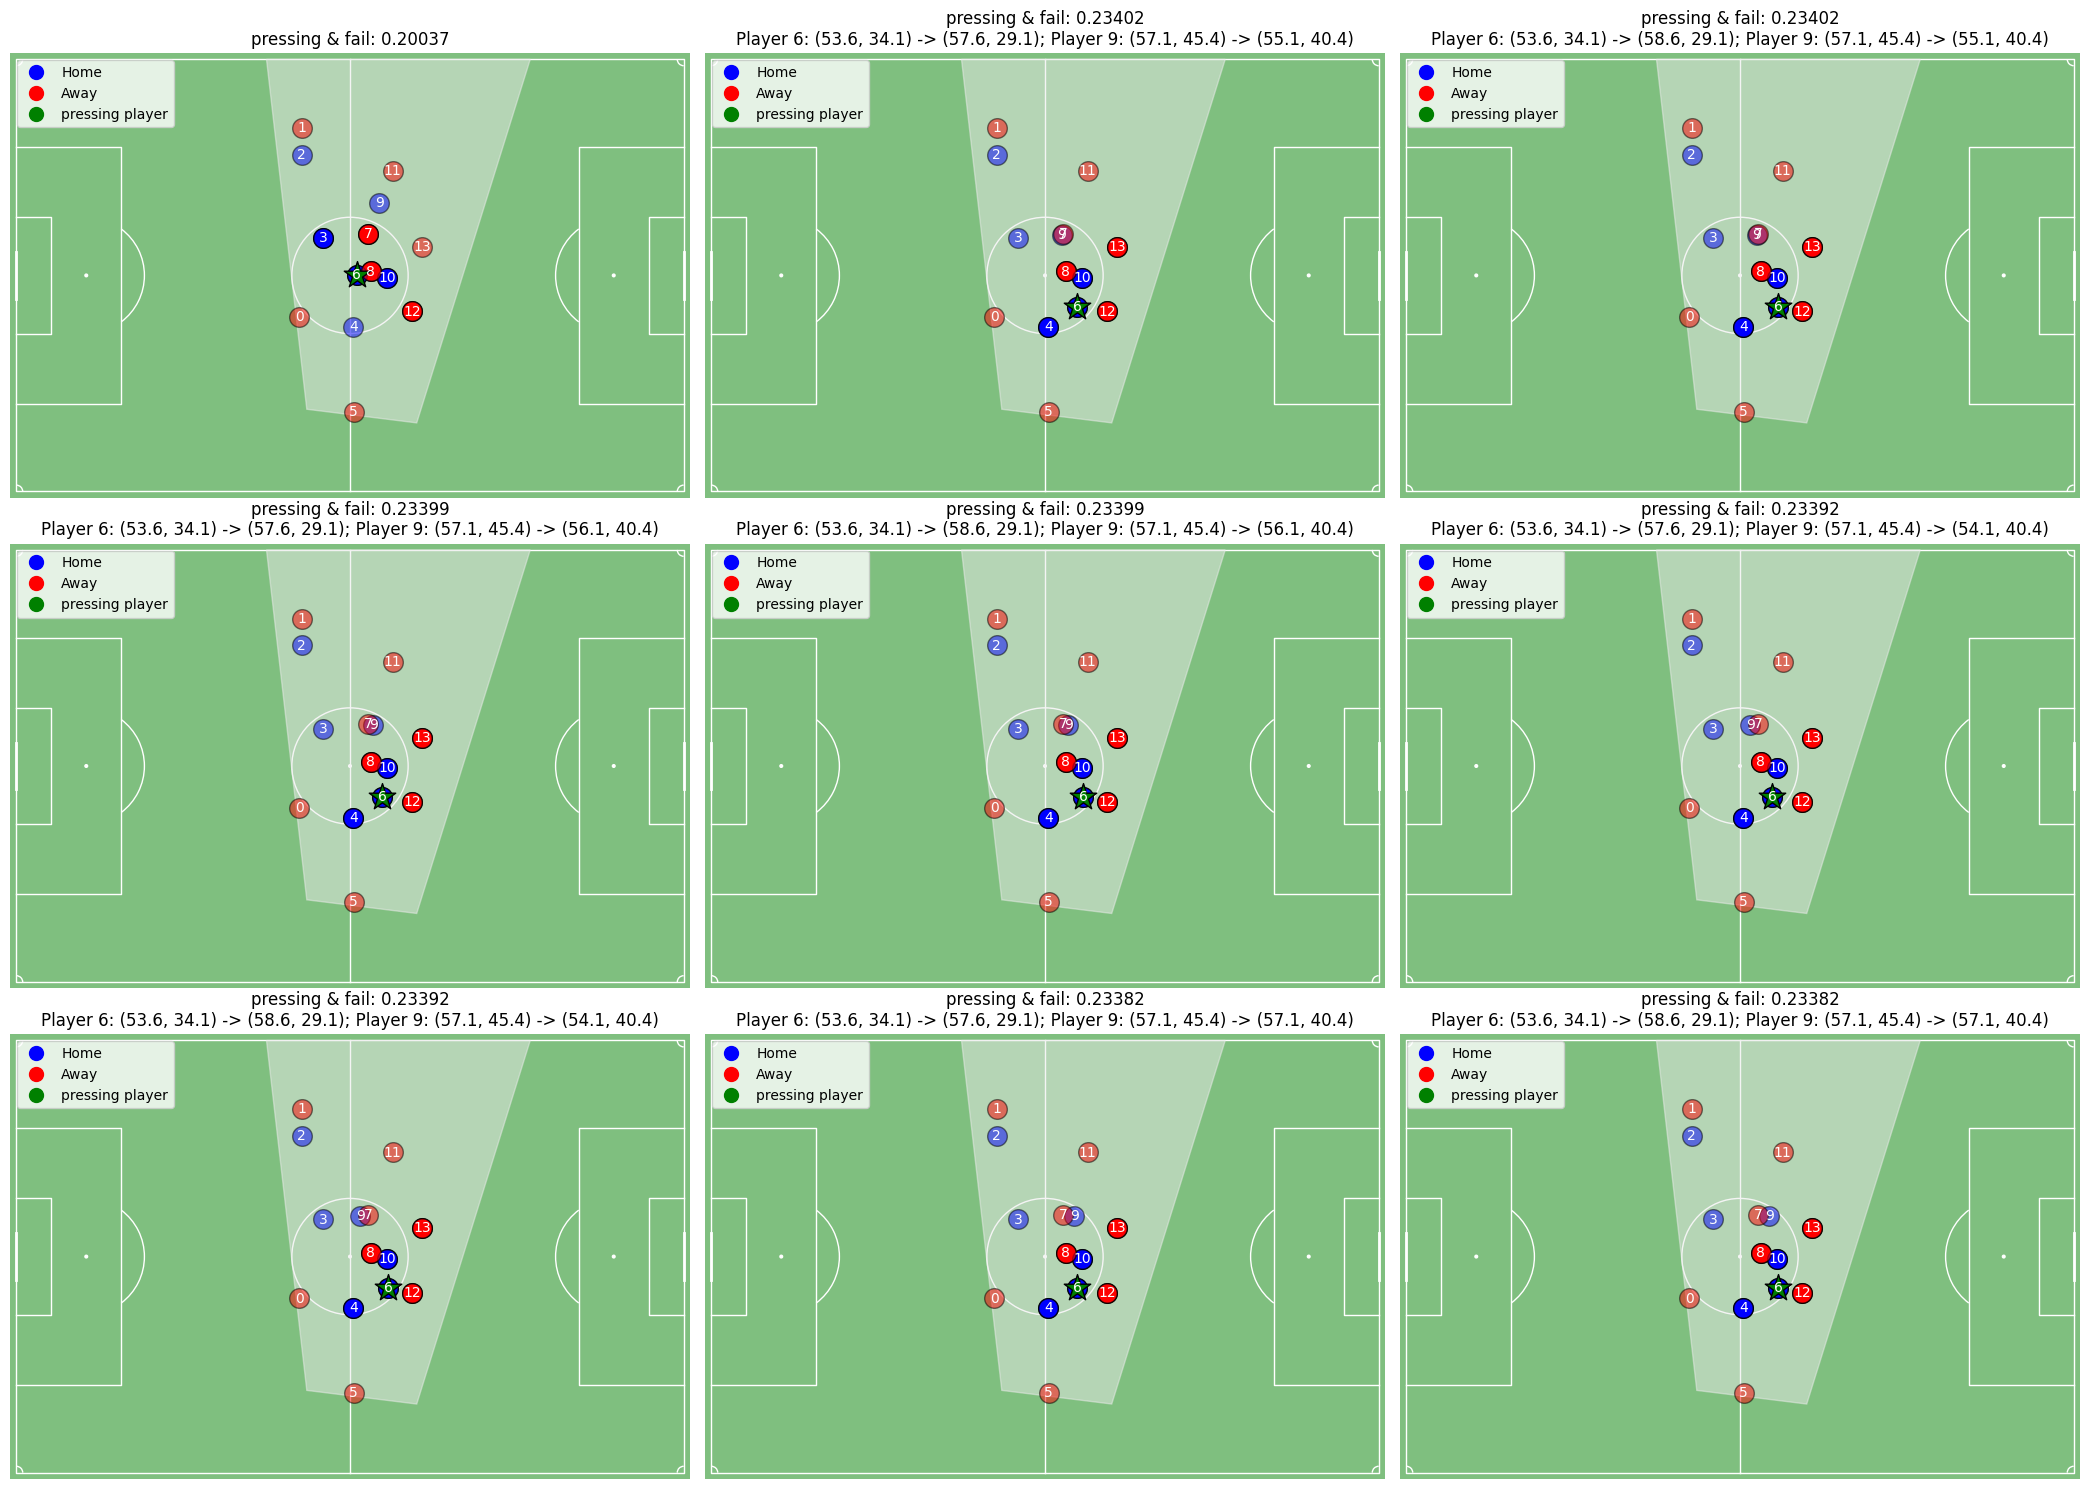

In [33]:
cols = int(k ** 0.5) + 1  # 가로
rows = (k + cols - 1) // cols  # 세로

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten()

for i, instance in enumerate(instances):
    action = instance.state # 모든 플레이가 왼쪽에서 오른쪽으로 플레이되므로..다시 원정은 오른쪽으로 변환

    # 예측 시 좌표를 left-to-right로 변환했지만, 시각화 단계에서는 home팀은 left->right, away팀은 right->left로 변환해야 함
    action = _fix_direction_of_play(action, home_team_id)
    action["freeze_frame_360"] = action.assign(away_idx=(action.team_id != home_team_id)).apply(
        lambda x: _sb_freeze_frame_to_spadl(x.freeze_frame_360, x.away_idx), axis=1
    )
    prob = instance.prob

    plot_action(
        action= action.squeeze(),
        home_team_id=home_team_id,
        prob=prob,
        ax=axes[i]
    )
    
    player_ids = instance.simulated_pos
    if player_ids is not None:
        simulated_position_lst = []

        for id, (simulated_x, simulated_y) in instance.simulated_pos.items():
            raw_x, raw_y = freeze_frame_360.loc[id, ['x', 'y']]
            simulated_pos_str = f"Player {id}: ({raw_x:.1f}, {raw_y:.1f}) -> ({simulated_x:.1f}, {simulated_y:.1f})"
            simulated_position_lst.append(simulated_pos_str)

        positions_info = '; '.join(simulated_position_lst)
        title_prefix = f'{action["type_name"].values[0]} & {action["result_name"].values[0]}: {prob:.5f}'
        axes[i].set_title(f"{title_prefix}\n{positions_info}")

plt.tight_layout()
plt.show()